# Exploratory Analysis

In this step we will analyse original data to understand how data is distributed.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from toolkit import Viz, Tools, PF

In [2]:
# Pre configure modules
sns.set()

In [3]:
# Get data
data, target_col, cat_cols, num_cols = PF.import_data()
X, y = data[cat_cols + num_cols], data[target_col]

# Add zero dense mark and strata
X, zdense_cols, f0_col = PF.full_zero_mark(X)
X, strt_col = PF.add_strata(X, y)
cntr_cols = [f0_col, strt_col]

# Undersample Data
Xrs, strt_rs = Tools.stratified_undersample(X, X[strt_col], PF.strata_p)
yrs = y.loc[Xrs.index]
data_rs = pd.concat([Xrs, yrs], axis=1)

## Prerequisites

### Visualization

For this section, we will plot several features to understand its distributions. We are going to mainly use two functions built in the `Viz` class of the **toolkit.py** file. These functions are:

```python
    def kernel_plot(cls, X, y, c_plot, remove_val=[np.nan], rug_sample=1000):
        """ Plots the KDE (Kernel Distribution Estimate) for specified metric columns. One chart per metric."""
    
    def count_plot(cls, X, y, c_plot, proportion=True):
        """Plots count plot for categorical data."""
        
    def corr_plot(cls, corr_matrix):
        """ Plots correlation heatmap. Plot will remove upper diagonal values for better readability. """
```

Some important comments to fully understand the information provided by `kernel_plot()` function. It is illustrated in the following figure:

<img src="images/Kernel Plot Explained.png">

The main takeaways:

- For each target it will show the mean and std in the legend.
- The name will include if certain metric values were removed before plotting, and the number of instances per target.
- The rug plot will sample randomly some data. To be more efficient on numerous datasets.

For **categorical variables, its best to analyze proportions** rather than total counts since the imbalance will shrink failure values.

Some important comments for `corr_plot()` function.

<img src="images/Corr Plot Explained.png">

Note that two correlation plots will be displayed. One is the correlation value (in 100's) and the other is the absolute correlation value (in 100's). The second one is useful when assessing magnitude rather than + / - relation. 

**Note:** I highly encourage you to check this building blocks in the **toolkit.py** file.

---
## Exploration - Categorical Data

### Device Features
First, we are going to check on the device id. We will try to generate some sub features based on its structure as you may see ahead.

The idea behind this is that sometimes each element of the id can mean a location, function or any kind of group. This could be useful to increase our categorical features.

- We will define a sublevel for every 2 characters in the device id. For a total of 4 sublevels.
- We can also combine sublevels depending on the granularity it generates.
- We will plot a proportion bar chart to see how failing and not failing devices are distributed among these derived features.

In [4]:
# Funtion to add device derived features and its names
def device_features(X, y):
    Xdev = X.copy()
    Xdev.insert(Xdev.shape[1], 'L1', Xdev['device'].str[0:2])
    Xdev.insert(Xdev.shape[1], 'L2', Xdev['device'].str[2:4])
    Xdev.insert(Xdev.shape[1], 'L12', Xdev['device'].str[0:4])
    #Xdev.insert(Xdev.shape[1], 'L3', Xdev['device'].str[4:6])
    #Xdev.insert(Xdev.shape[1], 'L4', Xdev['device'].str[6:])

    dev_cols = [c for c in ['L1', 'L2', 'L12', 'L3', 'L4'] if c in Xdev.columns]

    return Xdev, dev_cols

# Get device derived features
Xdev, dev_cols = device_features(X, y)

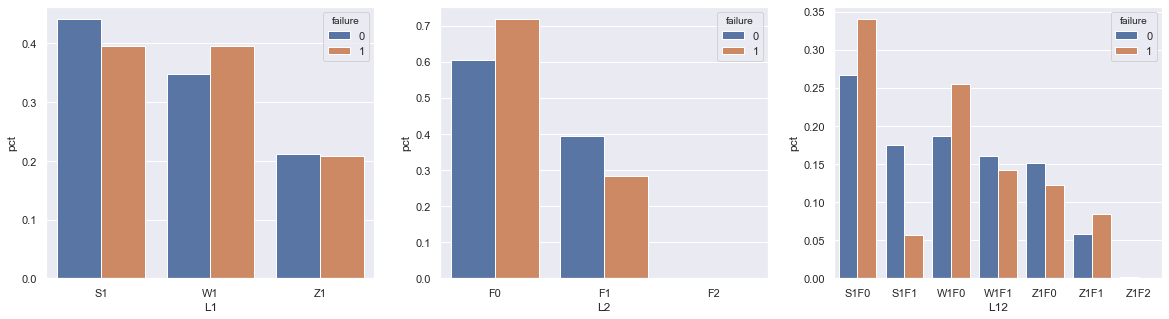

In [12]:
# Visualize Device Derived features
Viz.change_default(3)
Viz.count_plot(Xdev, y, dev_cols, proportion=True)

### Device Feature - Conclusions

- L1 and L2 groups data into few groups. Which can be useful.
- L1 may not be a good predictor since target is equally distributed among groups
- L2 can be a good predictor since target is not equally distributed among groups
- L12 seems to be the best option since target is divided in a more unequal way among groups
- Further subleveling will not be useful since it will have many values (sparse).

**Note:** Uncomment rows for Levels 3 and 4 in `device_features()` function if require to see proportion chart for them.

### Date Data

Next we are going to check on date features. We will try to generate some sub features from its components.

- We will define extract year, month, quarter, day, weekday, etc.
- We will plot a proportion bar chart to see how failing and not failing devices are distributed among these derived features.

In [16]:
# Function to add features extracted from date
def date_features(X, y):
    Xdt = X.copy()
    #Xdt['Y'] = Xdt['date'].dt.year
    Xdt['Q'] = Xdt['date'].dt.quarter
    Xdt['M'] = Xdt['date'].dt.month
    Xdt['D'] = Xdt['date'].dt.day
    Xdt['MW'] = Xdt['D'].div(8).apply(np.floor).add(1).astype(int)
    Xdt['WD'] = Xdt['date'].dt.weekday
    Xdt['WE'] = (Xdt['WD'] > 4).astype(int)

    date_cols = [c for c in ['Y', 'Q', 'M', 'D', 'MW', 'WD', 'WE'] if c in Xdt.columns]

    return Xdt, date_cols

Xdt, date_cols = date_features(X, y)

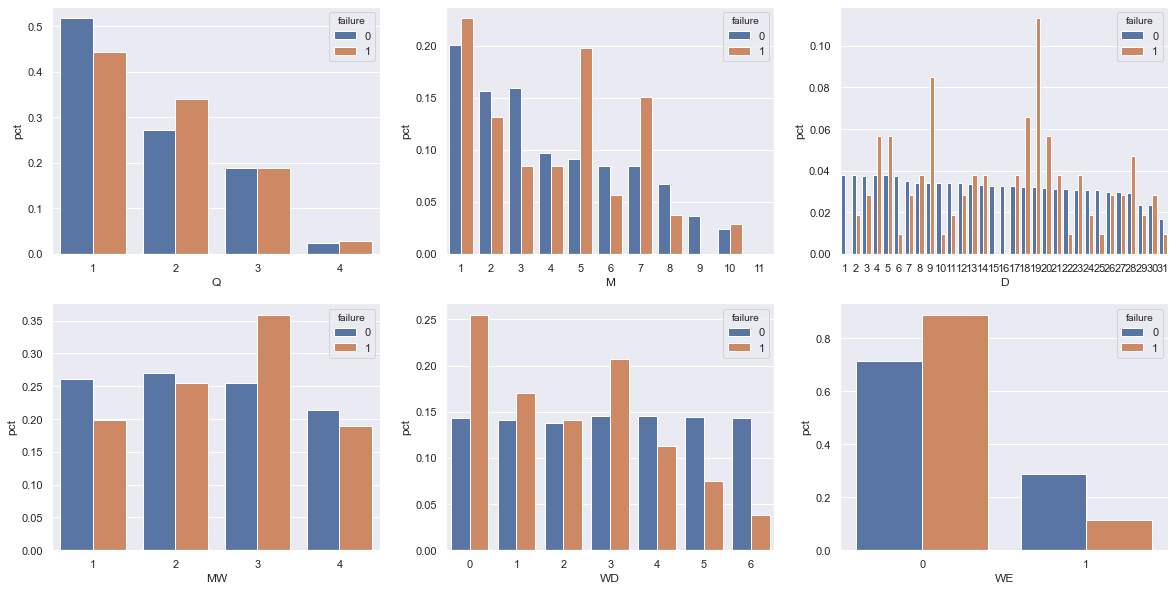

In [17]:
# Visualize Date Derived features
Viz.count_plot(Xdt, y, date_cols, proportion=True)

### Date Features - Conclusions

- Y is not necessary, since data is only for one year - 2015
- WE may not be good predictor since does not add much info compared to WD.
- Q may not be a good predictor since target values are mostly equally distributed per group.
- M, D, MW, WD may be good predictors since target is not equally distributed among groups.

**Note:** Uncomment row for Y in `date_features()` function if require to see proportion chart for year.

---
## Exploration - Numeric Data

### Original Data Metric Distributions - With / Without 0's

Bellow you can evaluate how the distributions for the entire dataset is affected when removing zero values on each metric.

**Note:** Execute one line of code at a time. The first line does not remove 0's, the second one does.

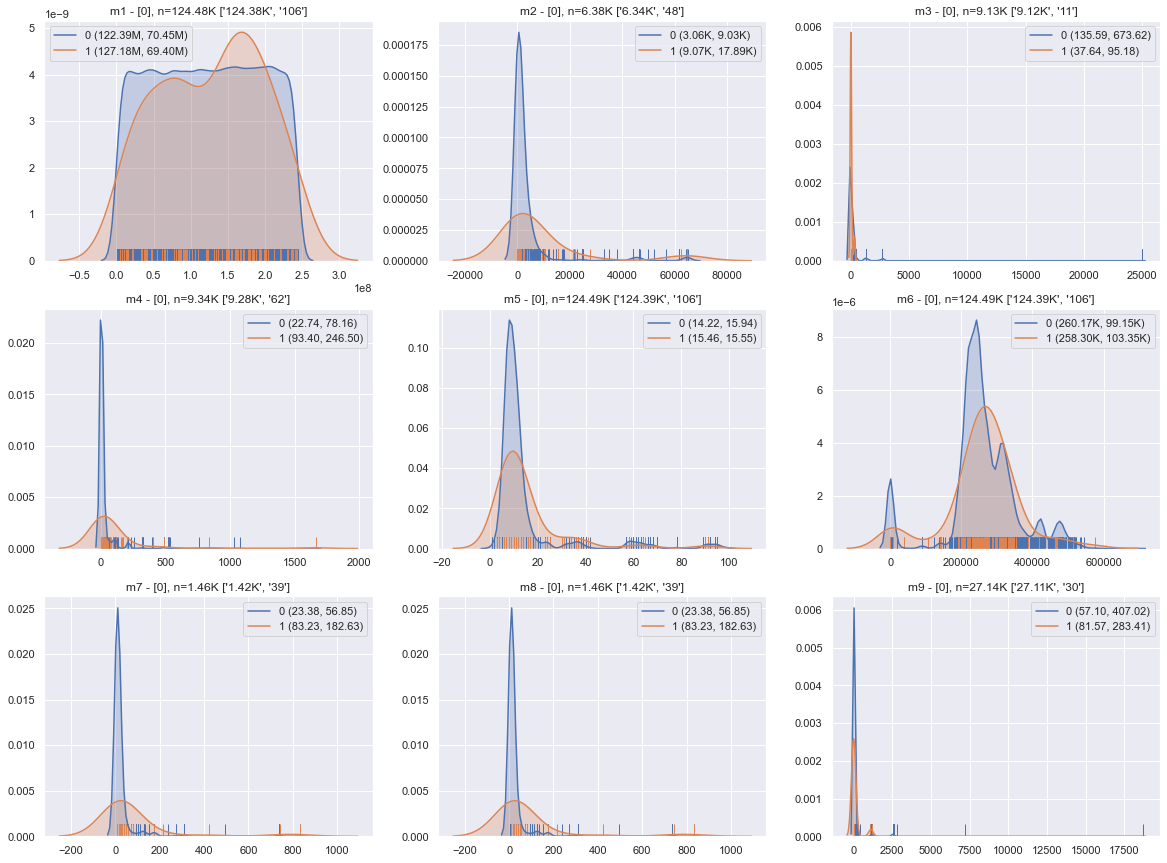

In [23]:
# Create distribution plot per metric and target
# Remove zeros or nothing as desired
#Viz.kernel_plot(X, y, num_cols, remove_val=[None], rug_sample=2500)
Viz.kernel_plot(X, y, num_cols, remove_val=[0], rug_sample=2500)

### Stratified Under sample Data Metric Distributions - With / Without 0's

Bellow you can evaluate how the distributions for a stratified under sample is affected when removing zero values on each metric.

**Note:** Execute one line of code at a time. The first line does not remove 0's, the second one does.

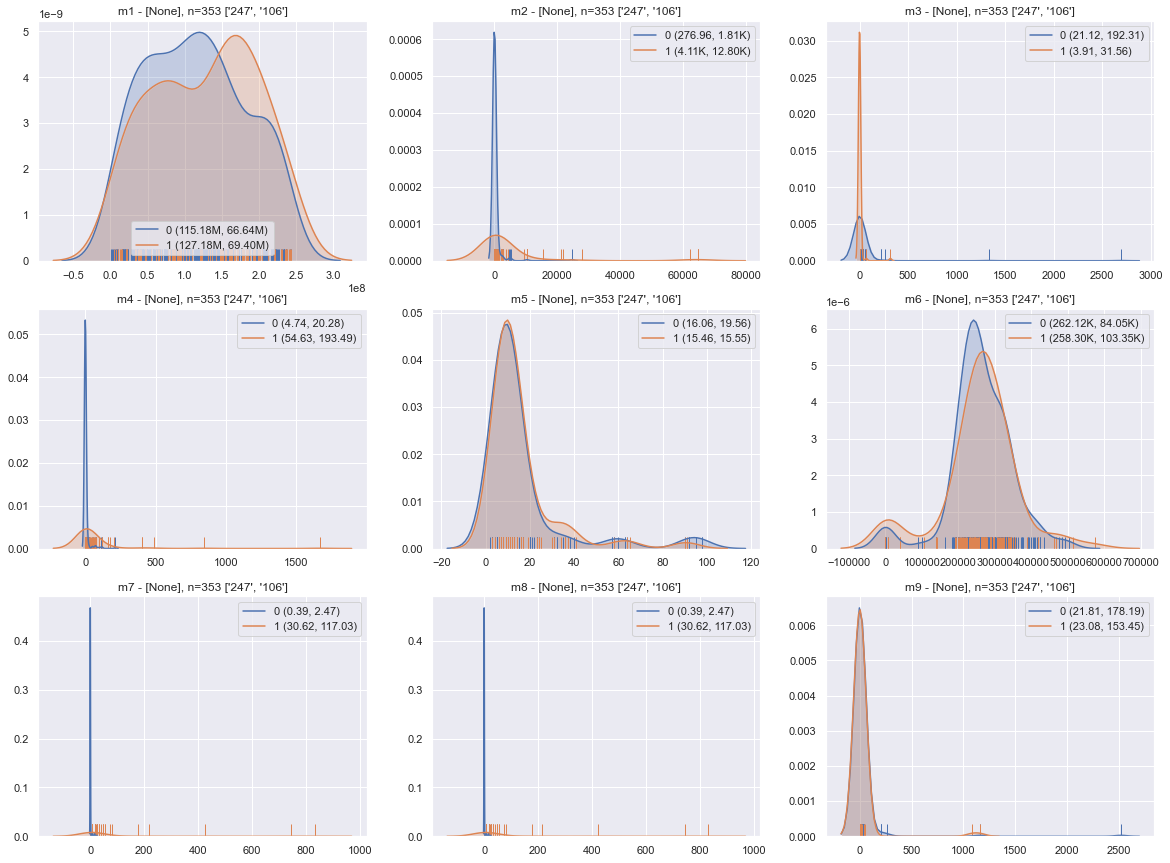

In [22]:
# Create distribution plot per metric and target for stratified undersampled data.
# Remove zeros or nothing as desired
Viz.kernel_plot(Xrs, yrs, num_cols, remove_val=[None], rug_sample=2500)
#Viz.kernel_plot(Xrs, yrs, num_cols, remove_val=[0], rug_sample=2500)

### Metric Distributions - Conclusions
#### For non-zero inflated metrics:

- M1, M5, M6 may not be good predictors since distribution of target variables are highly overlapped.


#### For zero inflated metrics:

- M2 may be good predictor. Extreme values are more frequent for failure. Ok values are highly concentrated.
- M3 may be a good predictor since failure values are concentrated in lower values than ok values (more spread).
- M4 may be a good predictor. Failure curve contains ok curve. Failure values can be more extreme.
- M7 and M8 seem duplicated. If they are, just one of them can be good predictor based on same argument as M4.
- M9 may not be a good predictor since distributions are mostly overlapped (contained for target value).

#### Outliers:

- Since near 70% of all data will have all measures equal to zero. Outliers may retain the relevant information.
- Outliers won’t be removed. In many metrics will guide the criteria to identify failure.

### Metrics Correlation

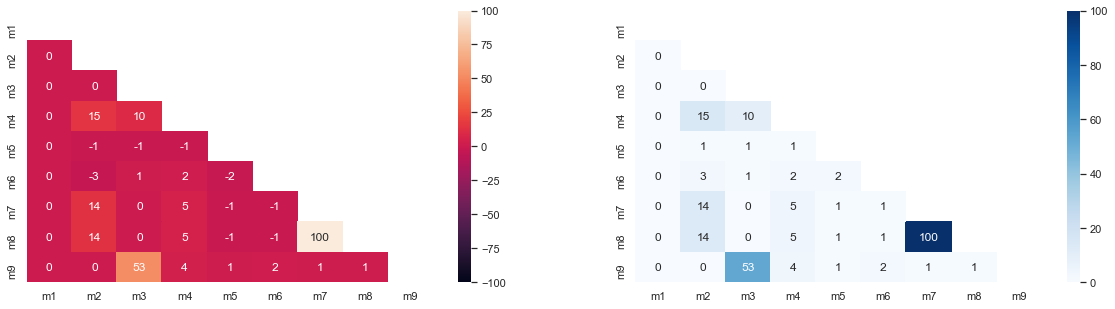

In [25]:
# Check correlation between metrics
Viz.change_default()
corr_matrix = Tools.get_corr(X, num_cols)
Viz.corr_plot(corr_matrix)

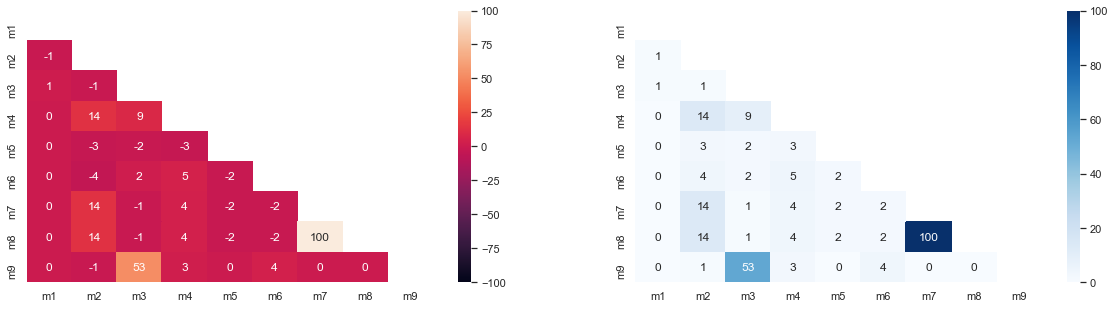

In [26]:
# Check correlation between metrics for Non Full Zero instances
corr_matrix = Tools.get_corr(X[X[f0_col] == 0], num_cols)
Viz.corr_plot(corr_matrix)

### Metrics Correlation - Conclusions

- M7 and M8 are duplicated (Correlation of 1). One of them will be removed from now on.
- M3 and M9 are moderately correlated. This should be treated for linear based ensemble model.
- For the rest of the metrics there is low correlation between data.
- Correlation is preserved for instances with no full zero values. Strata 1 and part of Strata 2